In [1]:
import math
import numpy as np
import json
import pandas as pd
import glob

from src.constants import OUTPUTS_DIR

In [2]:
tae_experiment_file = OUTPUTS_DIR / "estimate_effect_of_interleaver_conditional_entropy_turboae.json"

In [3]:
with open(tae_experiment_file, "r") as e:
    results = json.load(e)

exp_results = pd.DataFrame([{**d["results"], **d["preamble"]["args"], "interleaver": "interleaver" in d["preamble"] }for d in results["data"]])

snr_vals = [2.0]
exp_results = exp_results[exp_results["snr"].isin(snr_vals)]
exp_results = exp_results[["ce__mean", "ce__err", "block_len", "encoder_name", "snr", "interleaver"]]

In [4]:
def final_ce(group):
    (encoder_name, snr, is_turbo), exp_result = group
    return exp_result.sort_values("block_len")["ce__mean"].iloc[-1]

res = sorted(exp_results.groupby(["encoder_name", "snr", "interleaver"]), key=final_ce)[0][1]
res_16 = res[res["block_len"] == 16]
res_16

,ce__mean,ce__err,block_len,encoder_name,snr,interleaver
4,0.003623,0.000296,16,turboae_exact_nobd,2.0,True


In [5]:
experiment_file_1 = OUTPUTS_DIR / "train_turbo_table.json"
experiment_file_2 = OUTPUTS_DIR / "train_turbo_table_2.json"
experiment_file_3 = OUTPUTS_DIR / "train_turbo_table_3.json"
experiment_file_4 =OUTPUTS_DIR / "train_turbo_table_init_method.json"
experiment_file_5 = OUTPUTS_DIR / "train_turbo_table_fourier_table_constraint.json"
experiment_file_6 = OUTPUTS_DIR / "train_turbo_table_fourier_get_trajectory.json"
experiment_file_7 = OUTPUTS_DIR / "train_turbo_table_fourier_lr_search.json"
experiment_file_8 = OUTPUTS_DIR / "train_turbo_table_batch_random.json"
experiment_file_9 = OUTPUTS_DIR / "train_turbo_table_fourier_batch_random.json"
experiment_file_10 = OUTPUTS_DIR / "train_turbo_table_batch_random_2.json"

# exp_files = [experiment_file_1, experiment_file_2, experiment_file_3,experiment_file_4, experiment_file_5, experiment_file_6, experiment_file_7, experiment_file_8, experiment_file_9, experiment_file_10]
exp_files = [experiment_file_8, experiment_file_9, experiment_file_10]

In [6]:

training_runs = []
validation_runs = []
for exp_file in exp_files:
    with open(exp_file, "r") as e:
        results = json.load(e)
    for d in results["data"]:
        if "results" not in d:
            continue
            
        training_results = pd.DataFrame([res for res in d["results"] if res["type"] == "training"])
        validation_results = pd.DataFrame([{**res, "step": (d["results"][i-1]["step"] + 1 if i > 0 else 0)} for i, res in enumerate(d["results"]) if res["type"] == "validation"])
        preambles = pd.DataFrame([{**d["preamble"]["args"], **d["preamble"]}])
        print(preambles.columns)
        training_results = training_results.merge(preambles, how="cross")
        validation_results = validation_results.merge(preambles, how="cross")
        
        
        training_runs.append(training_results)
        validation_runs.append(validation_results)

training = pd.concat(training_runs, axis=0)
validation = pd.concat(validation_runs, axis=0)
arg_select_cols = ["block_len", "window", "snr", "init_method", "argument_hash"] + (["constraint"] if "constraint" in training.columns else []) + (["adam_lr"] if "adam_lr" in training.columns else []) + (["interleaver_type"] if "interleaver_type" in training.columns else [])
training_select_cols = ["xe", "ce", "ber", "bler", "step"] + (["true_ber"] if "true_ber" in training.columns else []) + \
    [c for c in ["noninterleaved_encoder.table_grad_l2", "interleaved_encoder.table_grad_l2", "noninterleaved_encoder.fourier_coefficients_grad_l2", "interleaved_encoder.fourier_coefficients_grad_l2"] if c in training.columns] + \
    [c for c in ["grad_avg_l2", "grad_avg_linf", "update_avg_l2", "update_avg_linf"] if c in training.columns]
val_select_cols = ["xe__mean", "ce__mean", "ber__mean", "bler__mean", "xe__err", "ce__err", "ber__err", "bler__err", "step", ] + (["true_ber__mean, true_ber__err"] if "true_ber" in validation.columns else [])

training = training[training_select_cols + arg_select_cols]
validation = validation[val_select_cols + arg_select_cols]

display(training.head())
display(validation.head())

Index(['experiment_id', 'block_len', 'interleaver_base_seed',
       'interleaver_type', 'batch_size', 'batches_per_update', 'snr',
       'validation_snr', 'num_steps', 'num_validation_steps', 'adam_lr',
       'delay', 'window', 'num_noninterleaved_streams',
       'num_interleaved_streams', 'use_inputs_for_loss', 'constraint',
       'save_every', 'output_dir', 'init_method', 'args', 'encoder', 'channel',
       'output_path', 'argument_hash'],
      dtype='object')
Index(['experiment_id', 'block_len', 'interleaver_base_seed',
       'interleaver_type', 'batch_size', 'batches_per_update', 'snr',
       'validation_snr', 'num_steps', 'num_validation_steps', 'adam_lr',
       'delay', 'window', 'num_noninterleaved_streams',
       'num_interleaved_streams', 'use_inputs_for_loss', 'constraint',
       'save_every', 'output_dir', 'init_method', 'args', 'encoder', 'channel',
       'output_path', 'argument_hash'],
      dtype='object')
Index(['experiment_id', 'block_len', 'interleaver_ba

,xe,ce,ber,bler,step,true_ber,grad_avg_l2,grad_avg_linf,update_avg_l2,update_avg_linf,block_len,window,snr,init_method,argument_hash,constraint,adam_lr,interleaver_type
0,0.028064,0.041104,0.014375,0.0900,0,0.011822,0.020289,0.007414,3.918020,0.100000,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random
1,0.015360,0.023057,0.006562,0.0375,1,0.006524,0.016035,0.005142,2.791685,0.100133,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random
2,0.013094,0.017595,0.005313,0.0500,2,0.004445,0.012367,0.004845,2.278576,0.100181,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random
3,0.004592,0.010766,0.002500,0.0200,3,0.002633,0.008499,0.003002,1.951162,0.098417,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random
4,0.018240,0.017758,0.006250,0.0425,4,0.004748,0.011003,0.004446,1.775698,0.096945,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random


,xe__mean,ce__mean,ber__mean,bler__mean,xe__err,ce__err,ber__err,bler__err,step,block_len,window,snr,init_method,argument_hash,constraint,adam_lr,interleaver_type
0,0.024518,0.037132,0.009953,0.07150,0.003077,0.002670,0.001540,0.008149,0,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random
1,0.007083,0.008893,0.002344,0.02275,0.002456,0.000964,0.000701,0.004716,50,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random
2,0.004247,0.006506,0.001609,0.01450,0.001227,0.001039,0.000588,0.003781,100,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random
3,0.003368,0.005290,0.001047,0.00825,0.001344,0.000840,0.000510,0.002861,150,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random
4,0.004368,0.006416,0.001516,0.01450,0.001461,0.000964,0.000524,0.003781,200,16,9,2.0,normal,7f68a483b502f7383b12626052a717e61882355f,opt_unit_power,0.1,batch_random


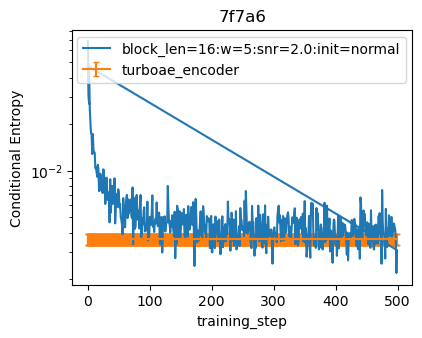

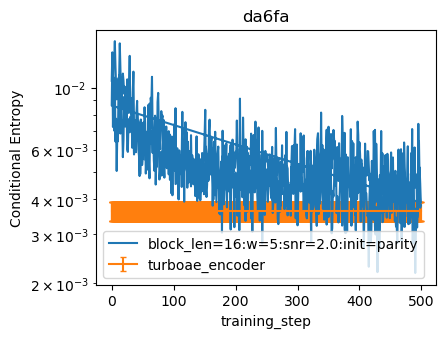

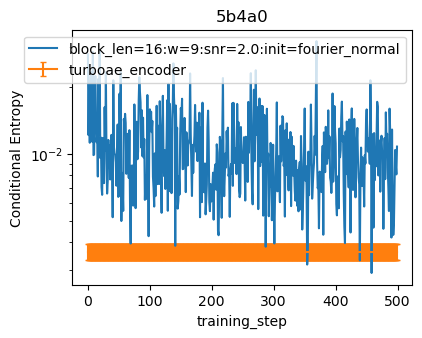

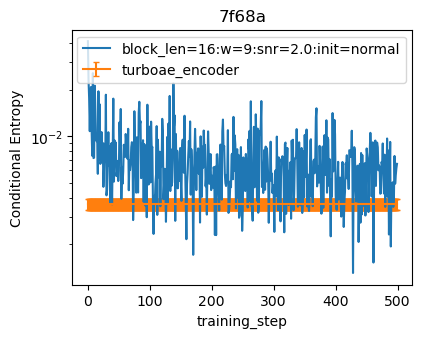

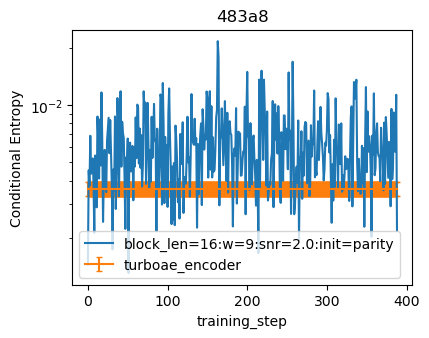

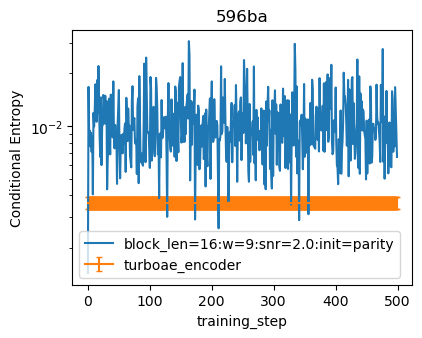

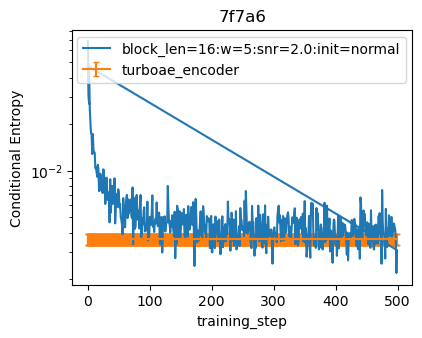

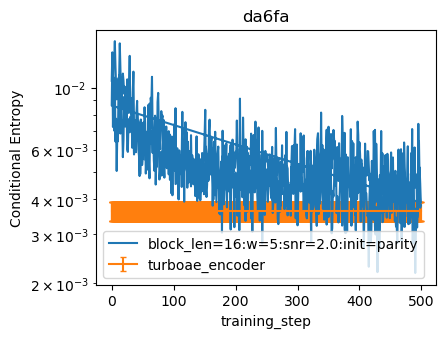

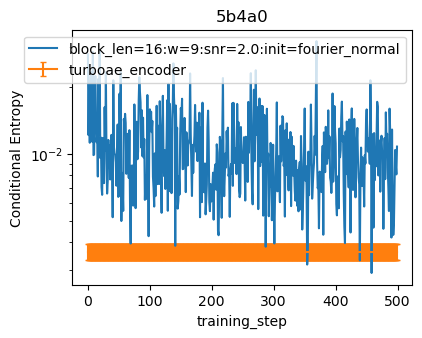

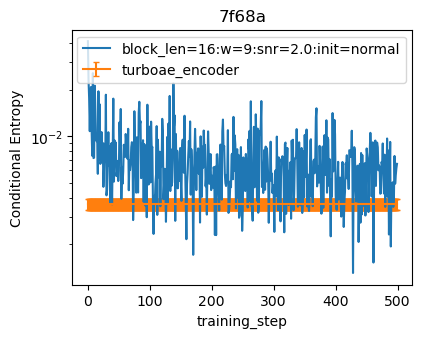

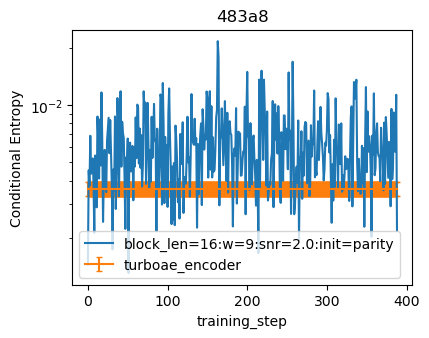

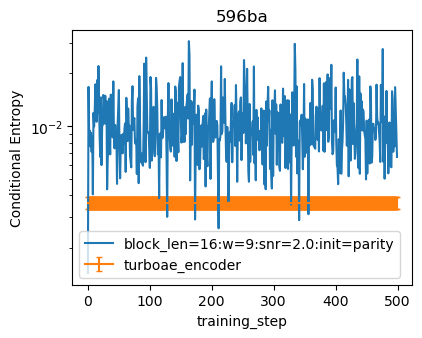

In [7]:


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (block_len, window, snr, init_method, argument_hash), training_result in training.groupby(["block_len", "window", "snr", "init_method", "argument_hash"], dropna=False):
    if len(training_result) < 100:
        continue
    # if window != 9:
        # continue
    # if training_result["interleaver_type"].isna().any():
        # continue
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    ax.errorbar(
        training_result["step"], 
        training_result["ce"], 
        # yerr=exp_result["xe__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"block_len={block_len}:w={window}:snr={snr}:init={init_method}"
    )
    bds = pd.merge(training_result["step"], res_16, how="cross")
    ax.errorbar(
        bds["step"], 
        bds["ce__mean"], 
        yerr=bds["ce__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"turboae_encoder"
    )
    ax.legend()
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel('training_step')
    ax.set_ylabel('Conditional Entropy')
    ax.set_title(argument_hash[:5])

    display(fig)

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (lr, block_len, window, snr, init_method, argument_hash), training_result in training.groupby(["adam_lr", "block_len", "window", "snr", "init_method", "argument_hash"]):
    if len(training_result) < 100:
        continue
    if "noninterleaved_encoder.table_grad_l2" not in training_result.columns:
        continue
    
    
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    
    ax.errorbar(
        training_result["step"], 
        training_result["noninterleaved_encoder.table_grad_l2"], 
        # yerr=exp_result["xe__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"block_len={block_len}:w={window}:lr={lr}:snr={snr}:init={init_method} - noninterleaved"
    )
    ax.errorbar(
        training_result["step"], 
        training_result["interleaved_encoder.table_grad_l2"], 
        # yerr=exp_result["xe__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"block_len={block_len}:w={window}:lr={lr}:snr={snr}:init={init_method} - interleaved"
    )
    ax.legend()
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel('training_step')
    ax.set_ylabel('Gradient l2')

    display(fig)

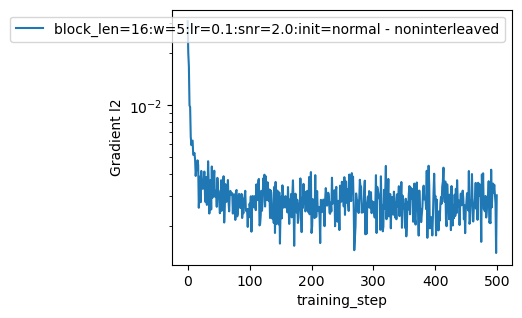

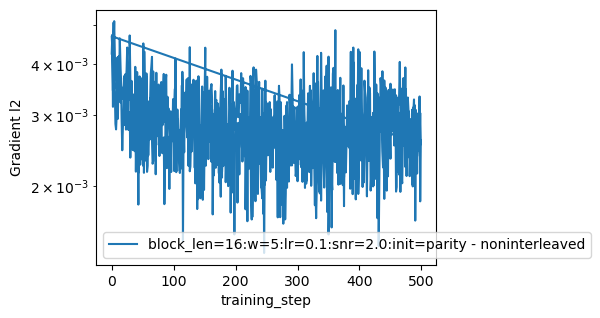

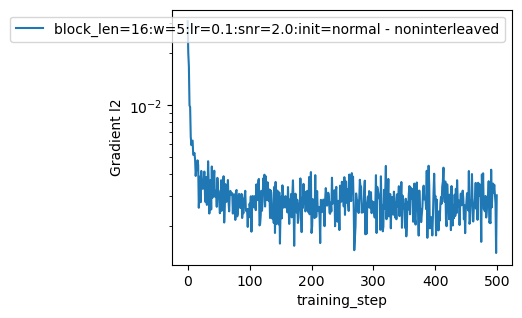

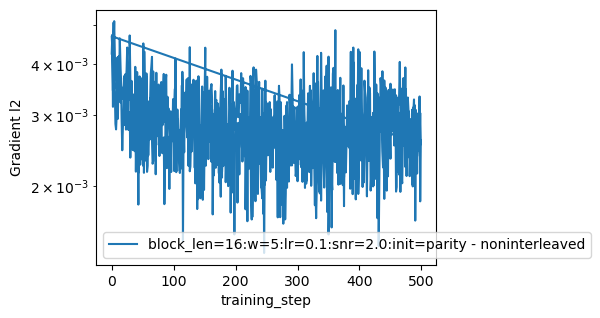

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (lr, block_len, window, snr, init_method, argument_hash), training_result in training.groupby(["adam_lr", "block_len", "window", "snr", "init_method", "argument_hash"]):
    if len(training_result) < 100:
        continue
    if "grad_avg_l2" not in training_result.columns:
        continue
    
    
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    
    ax.errorbar(
        training_result["step"], 
        training_result["grad_avg_l2"], 
        # yerr=exp_result["xe__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"block_len={block_len}:w={window}:lr={lr}:snr={snr}:init={init_method} - noninterleaved"
    )
    ax.legend()
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel('training_step')
    ax.set_ylabel('Gradient l2')

    display(fig)

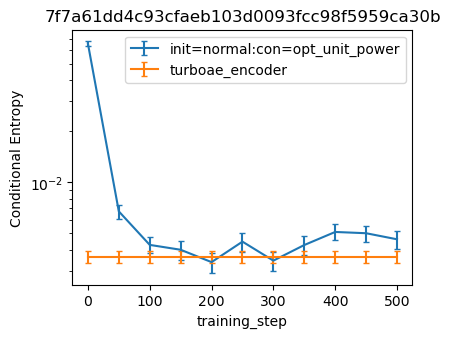

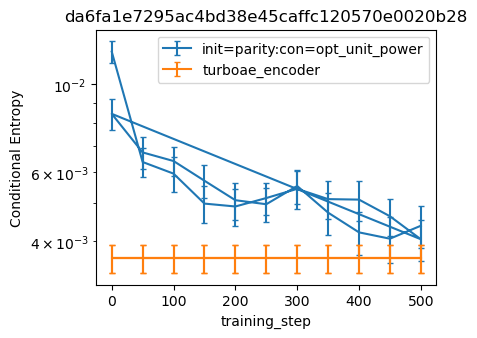

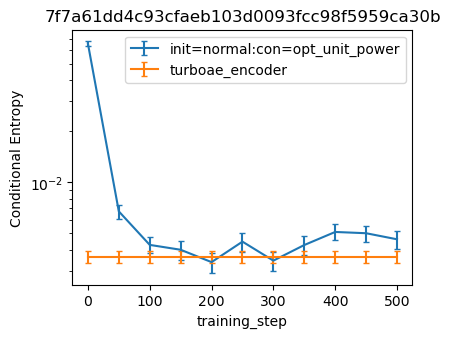

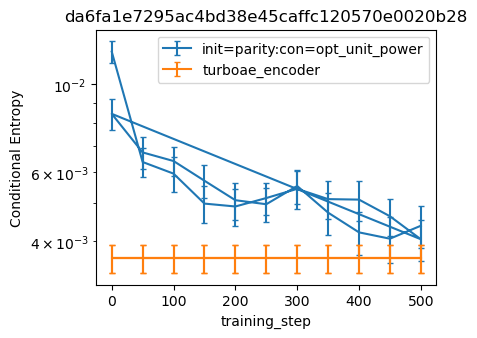

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (lr, block_len, window, snr, init_method, constraint, argument_hash), validation_result in sorted(validation.groupby(["adam_lr", "block_len", "window", "snr", "init_method", "constraint", "argument_hash"]), key=lambda x: x[0][-1]):
    if len(validation_result) < 3:
        continue
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    # label=f"block_len={block_len}:w={window}:lr={lr}:snr={snr}:init={init_method}:"
    label=f"init={init_method}:con={constraint}"
    
    # print("=====================")
    # print(label)
    # print(argument_hash)
    
    # print(label)
    # print(validation_result["step"])
    # print(validation_result["ce__mean"])
    # print(validation_result["ce__err"])
    ax.errorbar(
        validation_result["step"][validation_result["ce__mean"].notna()], 
        validation_result["ce__mean"].dropna(), 
        yerr=validation_result["ce__err"].dropna(), 
        linestyle='-',
        capsize=capsize,
        label=label
    )
    bds = pd.merge(validation_result["step"], res_16, how="cross")
    ax.errorbar(
        bds["step"], 
        bds["ce__mean"], 
        yerr=bds["ce__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"turboae_encoder"
    )
    ax.legend()
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_title(argument_hash)
    ax.set_xlabel('training_step')
    ax.set_ylabel('Conditional Entropy')

    display(fig)